### Fashion-MNIST Baseline Model
#### This notebook is my learning based on the wonderful course from DeepLzard: [PyTorch - Python Deep Learning Neural Network API](https://deeplizard.com/learn/playlist/PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG). In this notebook, I have built a baseline multiclass-classification model from scratch for the Fashion-MNIST dataset. ####

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Below we are importing all the imortant modules and libraries that will be used throughout this notebook.

In [2]:
#Pytorch-based imports
import torch
import imageio
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Python-specific imports
from itertools import product
from collections import namedtuple
from collections import OrderedDict
from IPython.display import display, clear_output
import time
import json

##### We have used PyTorch version '1.7.1+cpu'. I have not used GPU as it was not required.

In [3]:
torch.version.__version__

'1.7.1+cpu'

In [4]:
# # %load_ext tensorboard.notebook
# # %tensorboard --logdir logs

# from torch.utils.tensorboard import SummaryWriter
# !rm -rf ./logs/ 
# !mkdir ./logs/
# img_grey=img_t.mean(-3)
# batch_grey=batch_t.mean(-3)
# unsqueezed_weights = weights.unsqueeze(-1).unsqueeze_(-1)
# weights.shape,unsqueezed_weights.shape,img_t.shape
# img_weights=(img_t*unsqueezed_whyeights)
# img_weights
# unsqueezed_weights

# sample=iter(train)
# image,label=next(sample)
# image=image.squeeze()
# plt.figure(figsize=(4,5))
# plt.imshow(image,cmap="gray")
# print("label:",label)

# display_batch=iter(train_loader)
# batch,labels=next(display_batch)
# batch.shape
# grid=torchvision.utils.make_grid(batch, nrow=5)
# grid.shape
# plt.figure(figsize=(12,15))
# plt.imshow(grid.permute(1,2,0))

### Let's talk about the data we are going to work on as it is very important to know about your data.

##### The MNIST dataset, Modified National Institute of Standards and Technology database, is a famous dataset of handwritten digits that is commonly used for training image processing systems for machine learning. NIST stands for National Institute of Standards and Technology. The M in MNIST stands for modified, and this is because there was an original NIST dataset of digits that was modified to give us MNIST.

##### Fashion-MNIST as the name suggests is a dataset of fashion items. Specifically, the dataset has the following ten classes of fashion items:

###### Index	Label

0.	T-shirt/top
1. 	Trouser
2. 	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

##### The dataset consists of 70,000 images of hand written digits with the following split:
* 60,000 training images
* 10,000 testing images

##### Torchvision provides many built-in datasets in the torchvision.datasets module, so we used same module to load our Fashion-MNIST dataset directly.
* check if data is present in the specified path, if not download it.
* load only the train part
* transform the data to tensor form

#### We have used standardization to normalize the dataset. We calculated the mean and standard deviation of the data first and then incorpoarted it to our pipeline to normalize the dataset.

In [5]:
train=torchvision.datasets.FashionMNIST(
    root="../data/input",
    download=True,
    train=True,
    transform=transforms.Compose([transforms.ToTensor()])
)


#Calculate mean and standard deviation
loader = torch.utils.data.DataLoader(train, batch_size=len(train), num_workers=1)
data = next(iter(loader))
mean=data[0].mean()
std=data[0].std()

0it [00:00, ?it/s]

Extracting ../data/input/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/input/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/input/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/input/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/input/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/input/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/input/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/input/FashionMNIST/raw
Processing...


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [6]:
train=torchvision.datasets.FashionMNIST(
    root="../data/input/",
    download=True,
    train=True,
    transform=transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean,std)])
)

##### For simplicity, We have defined our Network with only 5 layers as below:
* 2 Convolution layers (Each Conv layer is followed by a ReLU activation and max pooling layer)
* 2 Linear layers ( Each Linear layer is followed only by a ReLU activation layer)
* Output layer

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1=nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2=nn.Linear(in_features=120, out_features=60)
        
        self.out=nn.Linear(in_features=60, out_features=10)
        
    def forward(self,t):
        #input layer
        t=t
        
        #1st conv-hidden layer
        t=F.relu(self.conv1(t))
        t=F.max_pool2d(t, kernel_size=2, stride=2)
        
        #2nd conv-hidden layer
        t=F.relu(self.conv2(t))
        t=F.max_pool2d(t, kernel_size=2, stride=2)
        
        #3rd linear-hidden layer
        t=t.reshape(-1,12*4*4)
        t=F.relu(self.fc1(t))
        
        #4th linear-hidden layer
        t=F.relu(self.fc2(t))
        
        #output layer
        t=self.out(t)
        return t

### Building a confusion Matrix 
#### We trained a dummy network to get some inference and show how we can build a confusion matrix. Below code should be used after completion of training of our model at the end.

In [8]:
def get_count_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum()

In [9]:
network=Network()
optimizer=optim.Adam(network.parameters(), lr=0.01)
train_loader=torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

#Trained our network
epochs=8
for epoch in range(epochs):
    
    total_correct=0
    total_loss=0
    for batch in train_loader:
        images,labels=batch
        preds=network(images)

        loss=F.cross_entropy(preds,labels)
        total_loss+=loss.item()
        total_correct+=get_count_correct(preds,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch} loss:{total_loss} Total Correct:{total_correct}")

Epoch:0 loss:331.52199195325375 Total Correct:47572
Epoch:1 loss:234.26707085967064 Total Correct:51413
Epoch:2 loss:218.31524005532265 Total Correct:51942
Epoch:3 loss:207.1747744679451 Total Correct:52347
Epoch:4 loss:206.13930544257164 Total Correct:52421
Epoch:5 loss:200.76010026037693 Total Correct:52622
Epoch:6 loss:197.32621236145496 Total Correct:52880
Epoch:7 loss:192.5560147613287 Total Correct:52976


In [10]:
#Building Confusion Matrix
def get_preds(model,data_loader):
    all_preds=torch.tensor([])
    with torch.no_grad():
        for batch in data_loader:
            images,labels=batch
            preds=model(images)
            
            all_preds=torch.cat((all_preds,preds), dim=0)
    return all_preds

pred_loader=torch.utils.data.DataLoader(train, batch_size=1000)
with torch.no_grad():
#     preds=get_preds(network,pred_loader).argmax(dim=1)
    preds=get_preds(network,pred_loader).argmax(dim=1)

confusion_matrix=torch.zeros(len(train.targets.unique()),len(train.targets.unique()), dtype=torch.int32)
paired_preds=torch.stack((train.targets,preds), dim=1)

for pair in paired_preds:
    true_label,predicted_label=pair.tolist()
    confusion_matrix[true_label][predicted_label]+=1


In [11]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[4695,    4,   37,  313,   19,    2,  865,    2,   63,    0],
        [   6, 5814,    2,  148,   10,    1,   13,    0,    6,    0],
        [  90,    0, 3942,   67, 1153,    3,  731,    0,   14,    0],
        [  74,    7,    9, 5668,   76,    0,  121,    2,   43,    0],
        [   5,    3,  122,  439, 4849,    0,  553,    0,   29,    0],
        [   1,    0,    0,   15,    0, 5669,    5,  130,  123,   57],
        [ 584,    4,  166,  228,  421,    2, 4541,    0,   53,    1],
        [   1,    0,    0,    8,    0,   99,    0, 5790,   19,   83],
        [   8,    2,    6,   20,   17,    5,   73,    8, 5853,    8],
        [   0,    0,    0,    4,    0,   37,    2,  299,   71, 5587]],
       dtype=torch.int32)


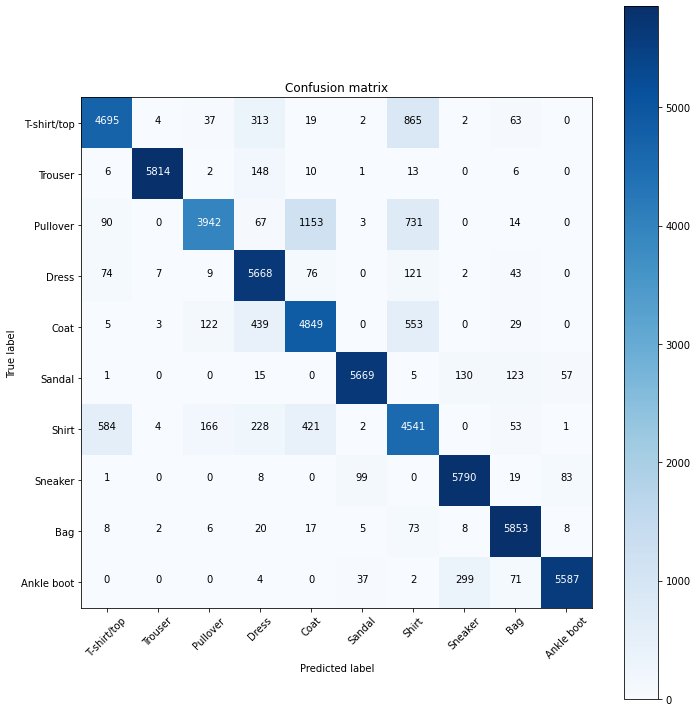

In [12]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix,train.classes)

#### For Hyperparameter tuning, we have built two classes which will be used to track and compare the results duirng mutliple runs with different parameter values.
* RunBuilder class
* RunManager class

###### Note: TensorBoard could not be used here on a kaggle kernel due to lot of complexities, hence related code lines are commented.

In [13]:
class RunBuilder:
    @staticmethod
    def get_runs(params):
        runs=[]
        
        Run=namedtuple("Run", params.keys())
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [14]:
class RunManager:
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.network = None
        self.loader = None
#         self.tb = None
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1
        self.network = network
        self.loader = loader
#         self.tb = SummaryWriter(comment=f'-{run}')
#         images, labels = next(iter(self.loader))
#         grid = torchvision.utils.make_grid(images)
#         self.tb.add_image('images', grid)
#         self.tb.add_graph(self.network, images)

    def end_run(self):
#         self.tb.close()
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
#         self.tb.add_scalar('Loss', loss, self.epoch_count)
#         self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

#         for name, param in self.network.named_parameters():
#             self.tb.add_histogram(name, param, self.epoch_count)
#             self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results['loss'] = loss
        results["accuracy"] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)

        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss, batch):
        self.epoch_loss += loss.item() * batch[0].shape[0]

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self.get_count_correct(preds, labels)

    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        ).to_csv(f'{fileName}.csv')

#         with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
#             json.dump(self.run_data, f, ensure_ascii=False, indent=4)
            
    def get_count_correct(self,preds,labels):
        return float(preds.argmax(dim=1).eq(labels).sum())

#### With above two powerful classes in place, we can test any number of Hyperparameters with minimal effort. We just need to add the key and values we want to test to our 'params' ordered-dictionary.

In [15]:
params=OrderedDict(
    lr=[0.1,0.01],
    batch_size=[100,300])

m=RunManager()

for run in RunBuilder.get_runs(params):
    network=Network()
    optimizer=optim.Adam(network.parameters(), lr=run.lr)
    train_loader=torch.utils.data.DataLoader(train, batch_size=run.batch_size, shuffle=True)
    
    
    epochs=5
    m.begin_run(run,network,train_loader)
    for epoch in range(epochs):
        m.begin_epoch()
        for batch in train_loader:
            images,labels=batch
            preds=network(images)

            loss=F.cross_entropy(preds,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss,batch)
            m.track_num_correct(preds,labels)
        m.end_epoch()
    m.end_run()
m.save("results")

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size
0,1,1,2.696941,0.100650,16.396177,16.396183,0.10,100
1,1,2,2.309115,0.099833,16.478580,32.906988,0.10,100
2,1,3,2.309883,0.099250,16.628914,49.545330,0.10,100
3,1,4,2.309240,0.099450,16.337620,65.893673,0.10,100
4,1,5,2.309722,0.101833,16.821454,82.724995,0.10,100
5,2,1,2.819495,0.099867,14.352983,14.353012,0.10,300
6,2,2,2.305288,0.098800,14.866327,29.229733,0.10,300
7,2,3,2.305572,0.098817,14.567641,43.807987,0.10,300
8,2,4,2.305925,0.100483,14.636917,58.455387,0.10,300
9,2,5,2.306410,0.098667,14.692245,73.157801,0.10,300


##### As per the above testing of runs,we found the best lr=0.01 and batch_size=300.

In [16]:
batch_size=300
lr=0.01
epochs=10


network=Network()
optimizer=optim.Adam(network.parameters(), lr=lr)
train_loader=torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    
    total_correct=0
    total_loss=0
    for batch in train_loader:
        images,labels=batch
        preds=network(images)

        loss=F.cross_entropy(preds,labels)
        total_loss+=loss.item()
        total_correct+=get_count_correct(preds,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch} loss:{total_loss} Total Correct:{total_correct}")

Epoch:0 loss:121.63634204864502 Total Correct:46123
Epoch:1 loss:75.6784086972475 Total Correct:51675
Epoch:2 loss:66.90443137288094 Total Correct:52496
Epoch:3 loss:62.940467208623886 Total Correct:53014
Epoch:4 loss:59.90317215025425 Total Correct:53275
Epoch:5 loss:58.27582532167435 Total Correct:53492
Epoch:6 loss:56.113839730620384 Total Correct:53756
Epoch:7 loss:53.64871099591255 Total Correct:53947
Epoch:8 loss:52.8780330568552 Total Correct:54023
Epoch:9 loss:53.46798352897167 Total Correct:54003


In [17]:
# import path
path='/kaggle/working/'
torch.save(network.state_dict(),'checkpoint.pth')

In [18]:
batch_size=1000
test=torchvision.datasets.FashionMNIST(root='../data/input', train=False,
                                       download=True,
                                       transform=transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean,std)]))
test_loader=torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 87 %


### Conclusion:
#### This baseline model is able to acheive 88% accuracy on test data which seems good given the network size and architecture. 